# Analysis of Chest X-Ray images

Neural networks have revolutionised image processing in several different domains. Among these is the field of medical imaging. In the following notebook, we will get some hands-on experience in working with Chest X-Ray (CXR) images.

The objective of this exercise is to identify images where an "effusion" is present. This is a classification problem, where we will be dealing with two classes - 'effusion' and 'nofinding'. Here, the latter represents a "normal" X-ray image.

This same methodology can be used to spot various other illnesses that can be detected via a chest x-ray. For the scope of this demonstration, we will specifically deal with "effusion".

#### Set desired working directory

In [1]:
#Take user input on desired working directory
import os
entered_path = input('Enter the working direcctory path where input files are available: \n')

#Update the entered path to python format if required
if('\\\\' in entered_path):
    updated_path = entered_path
    updated_path = updated_path.lstrip()
    updated_path = updated_path.rstrip()
else:
    updated_path = entered_path.replace('\\','\\\\')
    updated_path = updated_path.lstrip()
    updated_path = updated_path.rstrip()
print('\n')

#Set the working directory
os.chdir(updated_path)
#os.getcwd()

#Display set working directory
print('Set working directory is: \n',updated_path)

Enter the working direcctory path where input files are available: 
C:\Users\SUSHANT\Files\Upgrad March 2020 Cohort\Course 6 - Neural Networks\Module 4 - CNN Industry Applications\Working with Chest Xray Images


Set working directory is: 
 C:\\Users\\SUSHANT\\Files\\Upgrad March 2020 Cohort\\Course 6 - Neural Networks\\Module 4 - CNN Industry Applications\\Working with Chest Xray Images


## 1. Data Pre-processing

Our data is in the form of grayscale (black and white) images of chest x-rays. To perform our classification task effectively, we need to perform some pre-processing of the data.

First, we load all the relevant libraries.

In [2]:
#import keras
import tensorboard
import tensorflow as tf
from tensorflow import keras
from skimage import io
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

Point a variable to the path where the data resides. Note that to use the code below you will need to move the folders effusion/ and nofinding/ into one common folder. You can do something like this:

```
mkdir CXR_Data
move effusion CXR_Data
move nofinding CXR_Data
```

In [3]:
DATASET_PATH = './CXR_data'

# There are two classes of images that we will deal with
disease_cls = ['effusion', 'nofinding']
disease_cls

['effusion', 'nofinding']

Next, we read the "effusion" and "nofinding" images.

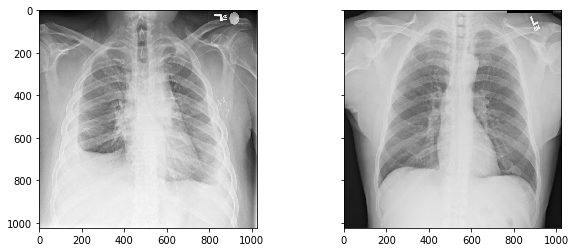

In [4]:
effusion_path = os.path.join(DATASET_PATH, disease_cls[0], '*')
effusion = glob.glob(effusion_path)
effusion = io.imread(effusion[0])

normal_path = os.path.join(DATASET_PATH, disease_cls[1], '*')
normal = glob.glob(normal_path)
normal = io.imread(normal[0])

f, axes = plt.subplots(1, 2, sharey=True)
f.set_figwidth(10)
    
axes[0].imshow(effusion, cmap='gray')
axes[1].imshow(normal, cmap='gray')

In [5]:
effusion.shape

(1024, 1024)

In [6]:
normal.shape

(1024, 1024)

### Data Augmentation ###

Now that we have read the images, the next step is data augmentation. We use the concept of a "data generator" that you learnt in the last section.

In [7]:
from skimage.transform import rescale
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=10,
    width_shift_range=0,
    height_shift_range=0,
    vertical_flip=False,)

def preprocess_img(img, mode):
    img = (img - img.min())/(img.max() - img.min())
    img = rescale(img, 0.25, multichannel=True, mode='constant')
    
    if mode == 'train':
        if np.random.randn() > 0:
            img = datagen.random_transform(img)
    return img

## 2. Model building

We will be using a Resnet in this (you learnt about Resnets previously). 

For this to work, the script that defines the resnet model (resnet.py) should reside in the same folder as this notebook

In [8]:
import resnet

img_channels = 1
img_rows = 256
img_cols = 256

nb_classes = 2

In [9]:
import numpy as np
#import keras
from tensorflow import keras

class AugmentedDataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, mode='train', ablation=None, disease_cls = ['nofinding', 'effusion'], 
                 batch_size=32, dim=(256, 256), n_channels=1, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = {}
        self.list_IDs = []
        self.mode = mode
        
        for i, cls in enumerate(disease_cls):
            paths = glob.glob(os.path.join(DATASET_PATH, cls, '*'))
            brk_point = int(len(paths)*0.8)
            if self.mode == 'train':
                paths = paths[:brk_point]
            else:
                paths = paths[brk_point:]
            if ablation is not None:
                paths = paths[:int(len(paths)*ablation/100)]
            self.list_IDs += paths
            self.labels.update({p:i for p in paths})
        
            
        self.n_channels = n_channels
        self.n_classes = len(disease_cls)
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'

        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
        
        delete_rows = []

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            img = io.imread(ID)
            img = img[:, :, np.newaxis]
            if img.shape == (1024, 1024,1):
                img = preprocess_img(img, self.mode)
                X[i,] = img
                y[i] = self.labels[ID]
            else:
                delete_rows.append(i)
                continue
                
        X = np.delete(X, delete_rows, axis=0)
        y = np.delete(y, delete_rows, axis=0)
        
        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

## 3. Ablation Run

In the previous notebook, you learnt about Ablation. Briefly, an ablation run is when you systematically modify certain parts of the input, in order to observe the equivalent change in the input.

For the following section, we'll be using the Data Generator concept that you previously worked on.

#### Ablation run with accuracy as the evaluation metrics

In [10]:
import datetime

In [11]:
# using resnet 18

model = resnet.ResnetBuilder.build_resnet_18((img_rows, img_cols, img_channels), nb_classes)
model.compile(loss='categorical_crossentropy', optimizer='SGD',
              metrics= ['accuracy'])

log_dir = ".\\logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir= log_dir, histogram_freq= 1, update_freq= 'epoch' )

# create data generator objects in train and val mode
# specify ablation=number of data points to train on
training_generator = AugmentedDataGenerator('train', ablation = 5)
validation_generator = AugmentedDataGenerator('val',ablation = 5)

# fit: this will fit the net on 'ablation' samples, only 1 epoch
model.fit(training_generator,
          validation_data= validation_generator,
          epochs= 5
         ,callbacks= [tensorboard_callback]
          )

Epoch 1/5
1/1 [==============================] - 2s 2s/step - loss: 1.5550 - accuracy: 0.9355
Epoch 2/5
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1/1 [==============================] - 1s 1s/step - loss: 1.3778 - accuracy: 0.9677
Epoch 3/5
1/1 [==============================] - 1s 1s/step - loss: 1.3526 - accuracy: 0.8750
Epoch 4/5
1/1 [==============================] - 1s 1s/step - loss: 1.3037 - accuracy: 0.9032
Epoch 5/5
1/1 [==============================] - 2s 2s/step - loss: 1.3322 - accuracy: 0.8710


#### Ablation run with AUC as the evaluation metrics

In [12]:
from sklearn.metrics import roc_auc_score
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import *

class roc_callback(Callback):
    
    def on_train_begin(self, logs={}):
        logs['val_auc'] = 0

    def on_epoch_end(self, epoch, logs={}):
        y_p = []
        y_v = []
        for i in range(len(validation_generator)):
            x_val, y_val = validation_generator[i]
            y_pred = self.model.predict(x_val)
            y_p.append(y_pred)
            y_v.append(y_val)
        y_p = np.concatenate(y_p)
        y_v = np.concatenate(y_v)
        roc_auc = roc_auc_score(y_v, y_p)
        print ('\nVal AUC for epoch{}: {}'.format(epoch, roc_auc))
        logs['val_auc'] = roc_auc

In [13]:
model = resnet.ResnetBuilder.build_resnet_18((img_rows, img_cols,img_channels), nb_classes)
model.compile(loss='categorical_crossentropy',optimizer='SGD',
              metrics=['accuracy'])

training_generator = AugmentedDataGenerator('train', ablation=20)
validation_generator = AugmentedDataGenerator('val', ablation=20)

auc_logger = roc_callback()

model.fit(training_generator,
                    validation_data=validation_generator,
                    epochs=5, callbacks=[auc_logger])

Epoch 1/5
5/5 [==============================] - ETA: 0s - loss: 1.3624 - accuracy: 0.9032
Val AUC for epoch0: 0.3793103448275862
5/5 [==============================] - 51s 10s/step - loss: 1.3624 - accuracy: 0.9032 - val_loss: 1.7116 - val_accuracy: 0.9688
Epoch 2/5
5/5 [==============================] - ETA: 0s - loss: 1.3105 - accuracy: 0.8896
Val AUC for epoch1: 0.5022321428571428
5/5 [==============================] - 45s 9s/step - loss: 1.3105 - accuracy: 0.8896 - val_loss: 2.7905 - val_accuracy: 0.9062
Epoch 3/5
5/5 [==============================] - ETA: 0s - loss: 1.2693 - accuracy: 0.9097
Val AUC for epoch2: 0.6982758620689655
5/5 [==============================] - 45s 9s/step - loss: 1.2693 - accuracy: 0.9097 - val_loss: 2.7741 - val_accuracy: 0.8750
Epoch 4/5
5/5 [==============================] - ETA: 0s - loss: 1.2630 - accuracy: 0.9097
Val AUC for epoch3: 0.5948275862068966
5/5 [==============================] - 45s 9s/step - loss: 1.2630 - accuracy: 0.9097 - val_loss: 2

Note: The model is not performing very well on AUC, the measure we had chosen. 
The main reason for this is the prevalence problem. There are just not as many abnormal cases available in the dataset. This problem will occur in almost all medical imaging problems (and for that matter, in most datasets that have a class imbalance)
To tackle this problem, we introduced 'weighted categorical cross-entropy'. This is a measure of loss, which applies weights to different forms of errors.

#### Ablation run with AUC as the evaluation metric and weightated cross entropy loss function

In [14]:
from functools import partial
import tensorflow.keras.backend as K
from itertools import product

def w_categorical_crossentropy(y_true, y_pred, weights):
    nb_cl = len(weights)
    final_mask = K.zeros_like(y_pred[:, 0])
    y_pred_max = K.max(y_pred, axis=1)
    y_pred_max = K.reshape(y_pred_max, (K.shape(y_pred)[0], 1))
    y_pred_max_mat = K.cast(K.equal(y_pred, y_pred_max), K.floatx())
    for c_p, c_t in product(range(nb_cl), range(nb_cl)):
        final_mask += (weights[c_t, c_p] * y_pred_max_mat[:, c_p] * y_true[:, c_t])
    cross_ent = K.categorical_crossentropy(y_true, y_pred, from_logits=False)
    return cross_ent * final_mask

bin_weights = np.ones((2,2))
bin_weights[0, 1] = 5
bin_weights[1, 0] = 5
ncce = partial(w_categorical_crossentropy, weights=bin_weights)
ncce.__name__ ='w_categorical_crossentropy'

In [15]:
model = resnet.ResnetBuilder.build_resnet_18((img_rows, img_cols,img_channels), nb_classes)
model.compile(loss=ncce,optimizer='SGD',
              metrics=['accuracy'])

training_generator = AugmentedDataGenerator('train', ablation=20)
validation_generator = AugmentedDataGenerator('val', ablation=20)

auc_logger = roc_callback()

model.fit(training_generator,
                    validation_data=validation_generator,
                    epochs=5, callbacks=[auc_logger])

Epoch 1/5
5/5 [==============================] - ETA: 0s - loss: 3.1577 - accuracy: 0.7226
Val AUC for epoch0: 0.4942528735632184
5/5 [==============================] - 49s 10s/step - loss: 3.1577 - accuracy: 0.7226 - val_loss: 4.0984 - val_accuracy: 0.9062
Epoch 2/5
5/5 [==============================] - ETA: 0s - loss: 1.8572 - accuracy: 0.8961
Val AUC for epoch1: 0.7833333333333334
5/5 [==============================] - 45s 9s/step - loss: 1.8572 - accuracy: 0.8961 - val_loss: 16.4145 - val_accuracy: 0.0938
Epoch 3/5
5/5 [==============================] - ETA: 0s - loss: 1.7766 - accuracy: 0.9091
Val AUC for epoch2: 0.26436781609195403
5/5 [==============================] - 45s 9s/step - loss: 1.7766 - accuracy: 0.9091 - val_loss: 2.8009 - val_accuracy: 0.6250
Epoch 4/5
5/5 [==============================] - ETA: 0s - loss: 1.7478 - accuracy: 0.9091
Val AUC for epoch3: 0.7
5/5 [==============================] - 46s 9s/step - loss: 1.7478 - accuracy: 0.9091 - val_loss: 12.8300 - val_

## 4. Final Run

After deeply examining our data and building some preliminary models, we are finally ready to build a model that will perform our prediction task.

In [16]:
class DecayLR(keras.callbacks.Callback):
    def __init__(self, base_lr=0.01, decay_epoch=1):
        super(DecayLR, self).__init__()
        self.base_lr = base_lr
        self.decay_epoch = decay_epoch 
        self.lr_history = []
        
    def on_train_begin(self, logs={}):
        K.set_value(self.model.optimizer.lr, self.base_lr)

    def on_epoch_end(self, epoch, logs={}):
        new_lr = self.base_lr * (0.5 ** (epoch // self.decay_epoch))
        self.lr_history.append(K.get_value(self.model.optimizer.lr))
        K.set_value(self.model.optimizer.lr, new_lr)

In [17]:
model = resnet.ResnetBuilder.build_resnet_18((img_rows, img_cols,img_channels), nb_classes)
sgd = optimizers.SGD(lr=0.005)

bin_weights = np.ones((2,2))
bin_weights[1, 1] = 10
bin_weights[1, 0] = 10
ncce = partial(w_categorical_crossentropy, weights=bin_weights)
ncce.__name__ ='w_categorical_crossentropy'

model.compile(loss=ncce,optimizer= sgd,
              metrics=['accuracy'])

training_generator = AugmentedDataGenerator('train', ablation=50)
validation_generator = AugmentedDataGenerator('val', ablation=50)

auc_logger = roc_callback()
filepath = './models/best_model.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_auc', verbose=1, save_best_only=True, mode='max')

decay = DecayLR()

'''
model.fit(training_generator,
          validation_data=validation_generator,
          epochs=2, callbacks=[auc_logger, decay, checkpoint])
'''

hist = model.fit(training_generator,
                 validation_data=validation_generator,
                 epochs=2, callbacks=[auc_logger, decay, checkpoint])

Epoch 1/2
13/13 [==============================] - ETA: 0s - loss: 2.3395 - accuracy: 0.5089
Val AUC for epoch0: 0.719029374201788
13/13 [==============================] - 144s 11s/step - loss: 2.3395 - accuracy: 0.5089 - val_loss: 2.6289 - val_accuracy: 0.1250
Epoch 2/2
13/13 [==============================] - ETA: 0s - loss: 2.2778 - accuracy: 0.5355
Val AUC for epoch1: 0.5696040868454662
13/13 [==============================] - 141s 11s/step - loss: 2.2778 - accuracy: 0.5355 - val_loss: 2.5329 - val_accuracy: 0.0938


In [18]:
hist.history

{'loss': [2.339473247528076, 2.2777655124664307],
 'accuracy': [0.5088607668876648, 0.5355330109596252],
 'val_loss': [2.6288745403289795, 2.5329084396362305],
 'val_accuracy': [0.125, 0.09375],
 'val_auc': [0.719029374201788, 0.5696040868454662]}

##### The monitor should be 'val_auc' instead of 'val_accuracy' during checkpoint.

## 5. Making a Prediction

In [19]:
val_model = resnet.ResnetBuilder.build_resnet_18((img_rows, img_cols,img_channels), nb_classes)
val_model.load_weights('models/best_model.hdf5')

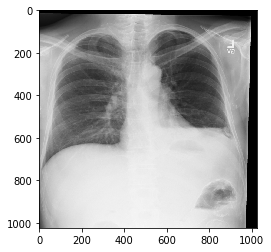

In [20]:
effusion_path = os.path.join(DATASET_PATH, disease_cls[0], '*')
effusion = glob.glob(effusion_path)
effusion = io.imread(effusion[-8])
plt.imshow(effusion,cmap='gray')

In [21]:
img = preprocess_img(effusion[:, :, np.newaxis], 'validation')
val_model.predict(img[np.newaxis,:])

array([[0.9192746 , 0.08072539]], dtype=float32)